# サポートベクターマシンのデモプログラム

サポートベクターマシンのデモプログラムです。  
サポートベクターマシンの中身に関してはこちら↓で解説しています。  
https://yuyumoyuyu.com/2021/01/24/supportvectormachine/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

%matplotlib inline

### データの整形

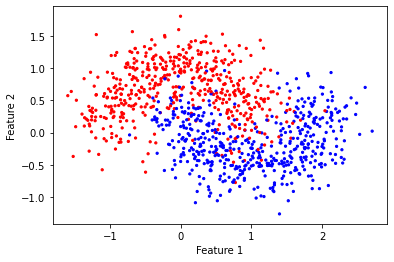

In [2]:
# sklearnのデータセットを用いる
from sklearn.datasets import make_moons

X, Y = make_moons(n_samples=1000,
                  random_state=0,
                  noise=0.3)

cmap = ListedColormap(('red', 'blue'))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y, cmap=cmap, s=5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.show()

In [3]:
# 特徴量は2次元の座標データ
print("X =", X[:10])

# クラスラベルは0/1データ
print("\nY =", Y[:10])

X = [[ 2.12957268  0.62990385]
 [ 1.8888818   0.1462573 ]
 [-0.19035705  0.38399281]
 [-0.40441619  0.19528201]
 [ 0.37301216 -0.42971569]
 [ 1.89472086  0.53718214]
 [ 0.8116396   0.67614677]
 [-0.0117708   0.93414674]
 [-0.90867526  0.54521076]
 [ 0.59737656 -0.76238004]]

Y = [1 1 0 1 1 1 0 0 0 1]


In [4]:
# データのtrain/test分割
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, stratify=Y, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(750, 2)
(250, 2)
(750,)
(250,)


### サポートベクターマシンによる分類

カーネル関数にはrbf(ガウシアン)カーネルを使用。  
ハイパラの調整にはこちら↓のサイトの高速化理論を参考にしています。  
https://datachemeng.com/fastoptsvrhyperparams/

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time

In [6]:
# ハイパーパラメータ最適化
t1 = time.time()
print("SVM")

# グリッドの設定
cs = 2**np.arange( -5, 11, dtype=float)          # C
gammas = 2**np.arange( -20, 11, dtype=float)     # γ
cv = 5 # 交差検証の分割数

# ガンマをグラム行列の分散が最大になるよう選択し固定
npX = np.array(X_train)
var_gram = []
for gamma in gammas:
    gram_matrix = np.exp(-gamma*((npX[:, np.newaxis] - npX)**2).sum(axis=2))
    var_gram.append(gram_matrix.var(ddof=1))
opt_gamma_tmp = gammas[np.where(var_gram == np.max(var_gram))[0][0]]

t2 = time.time()
elapsed_time = t2-t1
print("Elapsed time: {} sec\n".format(elapsed_time))

# Cの最適値探索
gs_C = GridSearchCV(SVC(kernel="rbf", gamma=opt_gamma_tmp), 
                      {'C': cs}, cv=cv, return_train_score=True)
gs_C.fit(X_train, Y_train)
opt_C = gs_C.best_params_['C']

print("best parameters: {}".format(gs_C.best_params_))
print("best cross-validation score: {:.3f}".format(gs_C.best_score_))

t2 = time.time()
elapsed_time = t2-t1
print("Elapsed time: {} sec\n".format(elapsed_time))

# γの最適値探索（なくてもいい）
gs_gamma = GridSearchCV(SVC(kernel="rbf", C=opt_C), 
                        {'gamma': gammas}, cv=cv, return_train_score=True)
gs_gamma.fit(X_train, Y_train)
opt_gamma = gs_gamma.best_params_['gamma']

print("best parameters: {}".format(gs_gamma.best_params_))
print("best cross-validation score: {:.3f}".format(gs_gamma.best_score_))

t2 = time.time()
elapsed_time = t2-t1
print("Elapsed time: {} sec".format(elapsed_time))


SVM
Elapsed time: 0.8816463947296143 sec

best parameters: {'C': 1.0}
best cross-validation score: 0.919
Elapsed time: 1.8057489395141602 sec

best parameters: {'gamma': 1.0}
best cross-validation score: 0.919
Elapsed time: 3.7326016426086426 sec


In [7]:
# SVMの分類結果ーハイパーパラメータ最適化後
svc = SVC(kernel="rbf", C=opt_C, gamma=opt_gamma).fit(X_train, Y_train)

print("SVR")
print("  Training set score: {:.3f}".format(svc.score(X_train, Y_train))) 
print("  Test set score: {:.3f}".format(svc.score(X_test, Y_test)))

# joblib.dump(svr, "path_svr.pkl")

SVR
  Training set score: 0.921
  Test set score: 0.916


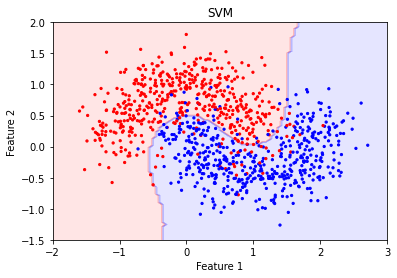

In [8]:
# 学習結果を可視化
x1 = np.linspace(-2.0, 3.0, 100)
x2 = np.linspace(-1.5, 2.0, 100)
x1_mesh, x2_mesh = np.meshgrid(x1, x2)    

z = svc.predict(np.array([x1_mesh.ravel(), x2_mesh.ravel()]).T)
z = z.reshape(x1_mesh.shape)

plt.contourf(x1_mesh, x2_mesh, z, cmap=cmap, alpha=0.1, linestyles=None)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y, cmap=cmap, s=5)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.title('SVM')

plt.show()